# EDA, Preprocessing, and Model Training

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split  # For supervised split
from sklearn.ensemble import RandomForestClassifier  # Our powerful classifier
from imblearn.over_sampling import SMOTE             # To fix class imbalance
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# Set a consistent style for plots
sns.set(style="whitegrid")

### 1. Load the Data 

In [2]:
try:
    df = pd.read_csv('creditcard.csv')
    print("Dataset 'creditcard.csv' loaded successfully.")
except FileNotFoundError:
    print("Error: 'creditcard.csv' not found.")
    print("Please download it from: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud")
    raise

Dataset 'creditcard.csv' loaded successfully.


### 2. Exploratory Data Analysis (EDA)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
print(f"Any missing values? {df.isnull().sum().any()}")

Any missing values? False


In [5]:
print("\nClass Distribution (Imbalance):")
class_counts = df['Class'].value_counts()
print(class_counts)
print(f"Percentage of Fraud: {((class_counts[1] / class_counts.sum()) * 100):.4f}%")
print("This confirms we need to handle imbalance.")


Class Distribution (Imbalance):
Class
0    284315
1       492
Name: count, dtype: int64
Percentage of Fraud: 0.1727%
This confirms we need to handle imbalance.


In [6]:
# 'Time' is seconds from first transaction. Let's drop it for this model.
if 'Time' in df.columns:
    df = df.drop('Time', axis=1)
    print("Dropped 'Time' column.")

Dropped 'Time' column.


### 3. Data Preprocessing

In [7]:
# V1-V28 are already scaled (PCA components).
# We ONLY need to scale the 'Amount' column.
df_processed = df.copy()
scaler = StandardScaler()
df_processed['Amount'] = scaler.fit_transform(df_processed[['Amount']])
print("'Amount' column has been scaled using StandardScaler.")

'Amount' column has been scaled using StandardScaler.


### 4. Split the Data for Training 

In [8]:
# Define features (X) and target (y)
features = [col for col in df_processed.columns if col != 'Class']
X = df_processed[features]
y = df_processed['Class']

# Split into training and testing sets.
# We test on 20% of the data.
# 'stratify=y' ensures the 0.17% of fraud is in both train and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Total samples: {len(X)}")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Total samples: 284807
Training samples: 227845
Testing samples: 56962


### 5. Handle Class Imbalance with SMOTE

In [9]:
print("--- Handling Imbalance with SMOTE ---")
print(f"Original training set shape: {X_train.shape}")
print("Original training set class distribution:")
print(y_train.value_counts())

print("\nApplying SMOTE...")
# Apply SMOTE *only* to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Resampled training set shape: {X_train_resampled.shape}")
print("Resampled training set class distribution:")
print(y_train_resampled.value_counts())

--- Handling Imbalance with SMOTE ---
Original training set shape: (227845, 29)
Original training set class distribution:
Class
0    227451
1       394
Name: count, dtype: int64

Applying SMOTE...
Resampled training set shape: (454902, 29)
Resampled training set class distribution:
Class
0    227451
1    227451
Name: count, dtype: int64


### 6. Train the Random Forest Model

In [10]:
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1  # Use all available CPU cores
)

# Train the model on our *resampled* training data
print("Training Random Forest model on resampled data...")
rf_classifier.fit(X_train_resampled, y_train_resampled)
print("Model training complete.")

Training Random Forest model on resampled data...
Model training complete.


### 7. Evaluate the Model

In [11]:
# Predict on the *original* test set (X_test)
# This is our real-world test.
y_pred = rf_classifier.predict(X_test)

print("\nEvaluation results on the *original, imbalanced* test set:")
print(classification_report(y_test, y_pred, target_names=['Normal (0)', 'Fraud (1)']))

print("\nAnalysis:")
print("Compare this to the old model (Recall: 0.24, Precision: 0.20).")


Evaluation results on the *original, imbalanced* test set:
              precision    recall  f1-score   support

  Normal (0)       1.00      1.00      1.00     56864
   Fraud (1)       0.87      0.83      0.85        98

    accuracy                           1.00     56962
   macro avg       0.94      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962


Analysis:
Compare this to the old model (Recall: 0.24, Precision: 0.20).


In [12]:
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)


Confusion Matrix:
[[56852    12]
 [   17    81]]


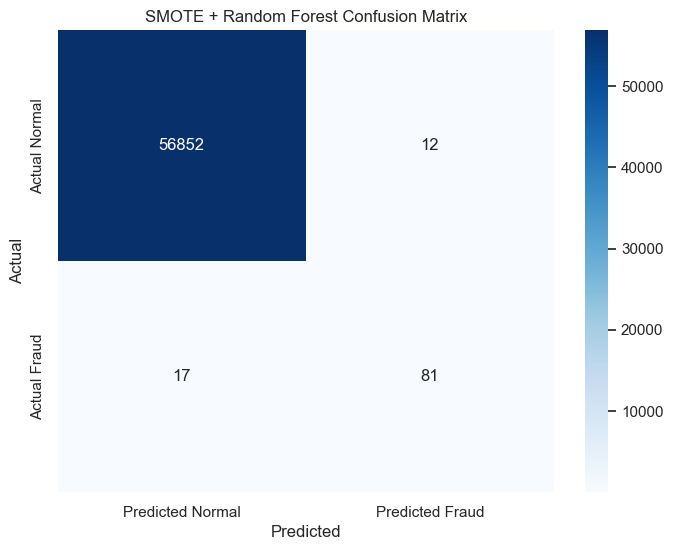

In [13]:
# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Predicted Normal', 'Predicted Fraud'],
    yticklabels=['Actual Normal', 'Actual Fraud']
)
plt.title('SMOTE + Random Forest Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show() 

### 7. Save Model and Scaler

In [14]:
print("--- Saving Artifacts ---")
# Save the trained model
joblib.dump(rf_classifier, 'random_forest_model.joblib')
print("Trained Random Forest model saved as 'random_forest_model.joblib'")

# Save the scaler (we still need this for new, incoming data)
joblib.dump(scaler, 'amount_scaler.joblib')
print("Fitted StandardScaler saved as 'amount_scaler.joblib'")

--- Saving Artifacts ---
Trained Random Forest model saved as 'random_forest_model.joblib'
Fitted StandardScaler saved as 'amount_scaler.joblib'
